In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'SBSW'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,1007,-608,399,145,144,94,18,262,0,...,1940,200,48,0,347,144,1022,295,-145,748
1,2014-06-30,920,-594,327,50,114,75,27,223,69,...,2530,280,52,0,415,120,1174,234,-126,792
2,2014-12-31,1093,-729,364,89,49,86,28,168,64,...,2415,235,48,0,309,226,1119,140,-174,915
3,2015-06-30,861,-663,199,7,70,86,32,189,61,...,2308,235,45,0,325,261,1111,116,-131,914
4,2015-12-31,920,-622,298,35,46,105,26,177,47,...,1819,178,128,0,344,116,854,157,-131,920


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
16,2021-12-31,2022-02-11,2877,5461,-3821,1640,544,1900,465,1573,...,0,9598,951,7,0,1290,1267,4496,1267,-477
17,2022-06-30,2022-07-21,2831,4570,-3263,1307,803,1673,437,1658,...,0,9736,883,7,0,1152,1275,4249,285,-399
18,2022-12-31,2023-02-11,2831,3878,-2945,933,359,1531,440,1549,...,0,9783,919,7,0,1187,1327,4441,664,-572
19,2023-06-30,2023-07-21,2831,3326,-2728,598,427,1176,425,1364,...,0,9569,816,7,0,957,1336,4260,272,-596
20,2023-12-31,2024-02-11,2831,2846,-2689,157,-2459,1376,479,1420,...,0,7696,887,834,0,1962,1343,4919,113,-621


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
16,2021-12-31,2022-02-11,2877,5461,-3821,1640,544,1900,465,1573,...,9598,951,7,0,1290,1267,4496,1267,-477,1
17,2022-06-30,2022-07-21,2831,4570,-3263,1307,803,1673,437,1658,...,9736,883,7,0,1152,1275,4249,285,-399,1
18,2022-12-31,2023-02-11,2831,3878,-2945,933,359,1531,440,1549,...,9783,919,7,0,1187,1327,4441,664,-572,1
19,2023-06-30,2023-07-21,2831,3326,-2728,598,427,1176,425,1364,...,9569,816,7,0,957,1336,4260,272,-596,1
20,2023-12-31,2024-02-11,2831,2846,-2689,157,-2459,1376,479,1420,...,7696,887,834,0,1962,1343,4919,113,-621,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
16,2021-12-31,2022-02-11,2877,5461.0,-3821.0,1640.0,544.0,1900.0,465.0,1573.0,...,9598.0,951.0,7.0,0.0,1290.0,1267.0,4496.0,1267.0,-477.0,1
17,2022-06-30,2022-07-21,2831,4570.0,-3263.0,1307.0,803.0,1673.0,437.0,1658.0,...,9736.0,883.0,7.0,0.0,1152.0,1275.0,4249.0,285.0,-399.0,1
18,2022-12-31,2023-02-11,2831,3878.0,-2945.0,933.0,359.0,1531.0,440.0,1549.0,...,9783.0,919.0,7.0,0.0,1187.0,1327.0,4441.0,664.0,-572.0,1
19,2023-06-30,2023-07-21,2831,3326.0,-2728.0,598.0,427.0,1176.0,425.0,1364.0,...,9569.0,816.0,7.0,0.0,957.0,1336.0,4260.0,272.0,-596.0,1
20,2023-12-31,2024-02-11,2831,2846.0,-2689.0,157.0,-2459.0,1376.0,479.0,1420.0,...,7696.0,887.0,834.0,0.0,1962.0,1343.0,4919.0,113.0,-621.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,5.447186,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,0.473196,0.526804,21.425532,6.08,13.986111,67.555556,0.396226,0.143992,0.149485,0.315904
1,2014-02-24,5.481401,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,0.473196,0.526804,21.425532,6.08,13.986111,67.555556,0.396226,0.143992,0.149485,0.315904
2,2014-03-03,6.145192,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,0.473196,0.526804,21.425532,6.08,13.986111,67.555556,0.396226,0.143992,0.149485,0.315904
3,2014-03-10,6.624216,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,0.473196,0.526804,21.425532,6.08,13.986111,67.555556,0.396226,0.143992,0.149485,0.315904
4,2014-03-17,6.068793,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,0.473196,0.526804,21.425532,6.08,13.986111,67.555556,0.396226,0.143992,0.149485,0.315904


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,5.447186,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,67.555556,0.396226,0.143992,0.149485,0.315904,14.049983,4.438448,2.023086,2.459034,4.630108
1,2014-02-24,5.481401,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,67.555556,0.396226,0.143992,0.149485,0.315904,14.138234,4.466327,2.035793,2.471742,4.659191
2,2014-03-03,6.145192,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,67.555556,0.396226,0.143992,0.149485,0.315904,15.850356,5.007193,2.282325,2.718274,5.223413
3,2014-03-10,6.624216,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,67.555556,0.396226,0.143992,0.149485,0.315904,17.085908,5.397509,2.460235,2.896183,5.630583
4,2014-03-17,6.068793,2013-12-31,1007.0,0.387701,1.227273,748.0,880.0,1.176471,144.0,...,67.555556,0.396226,0.143992,0.149485,0.315904,15.653301,4.944943,2.253951,2.689899,5.158474


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

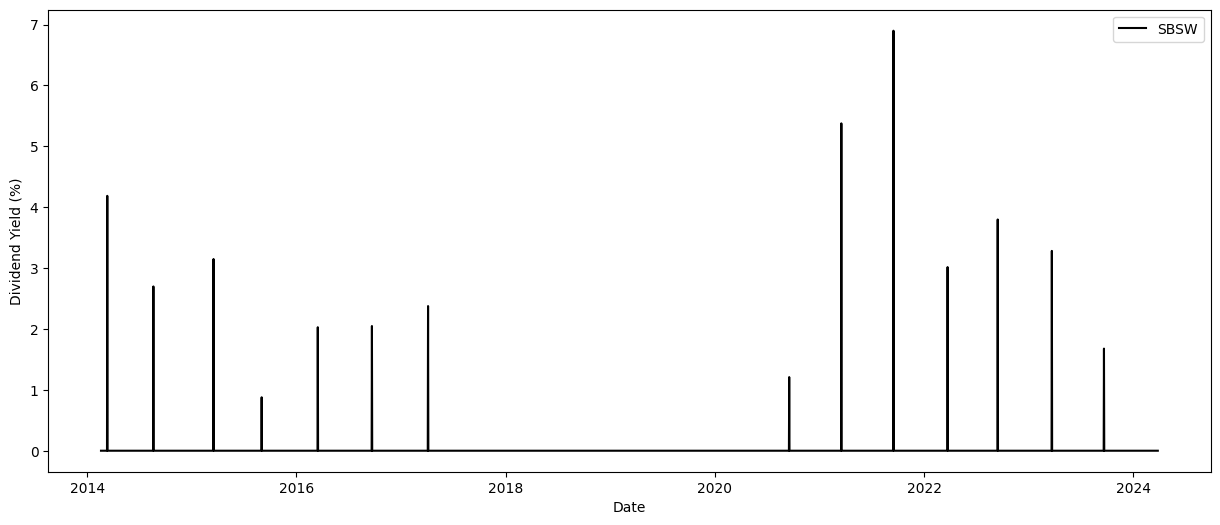

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


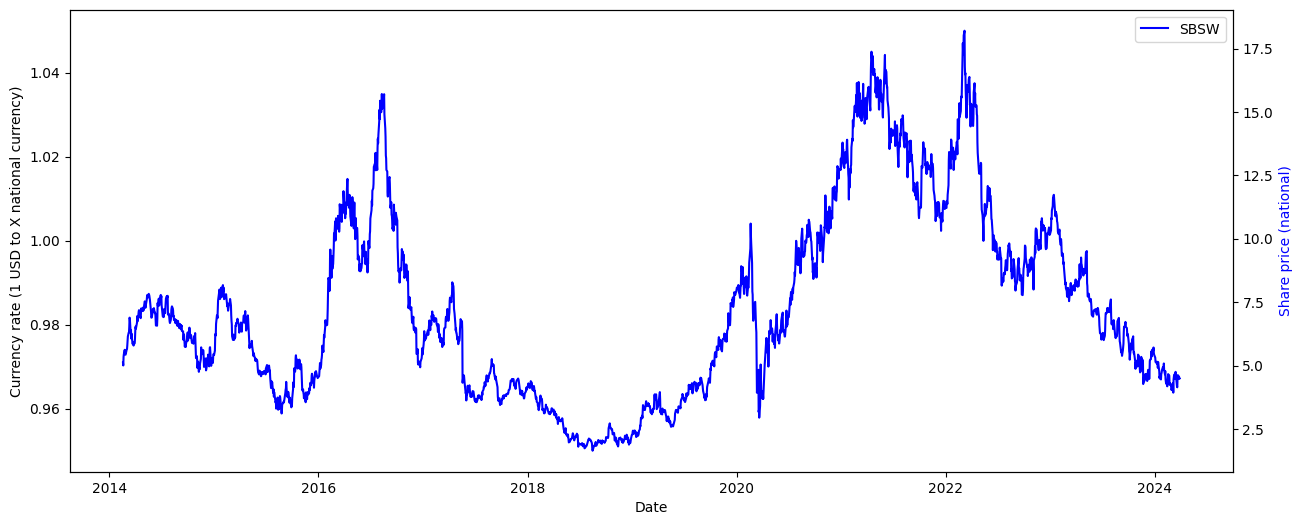

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

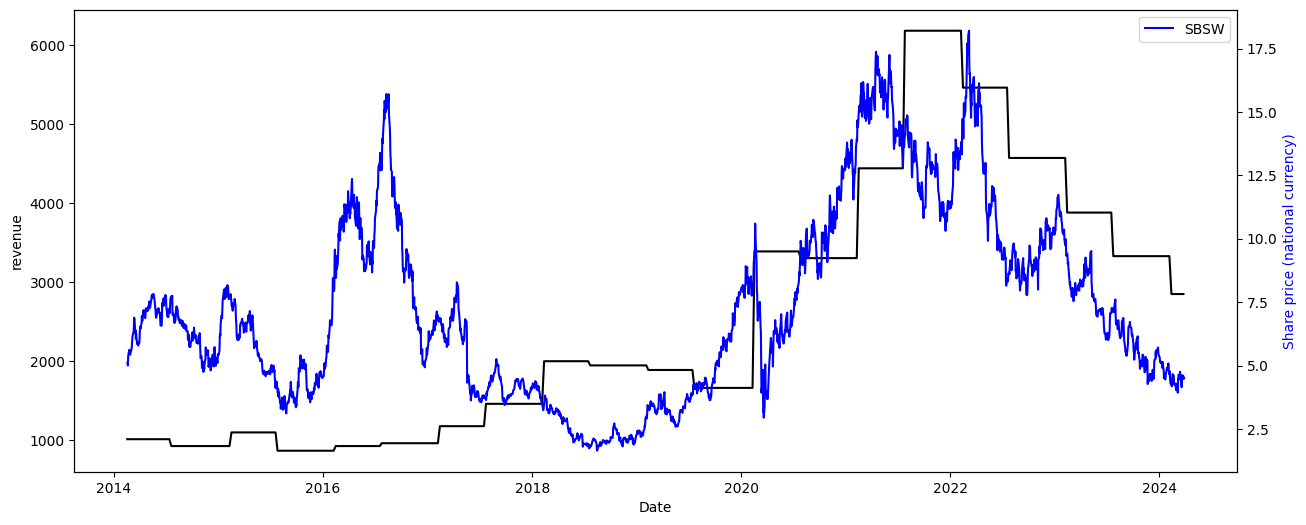

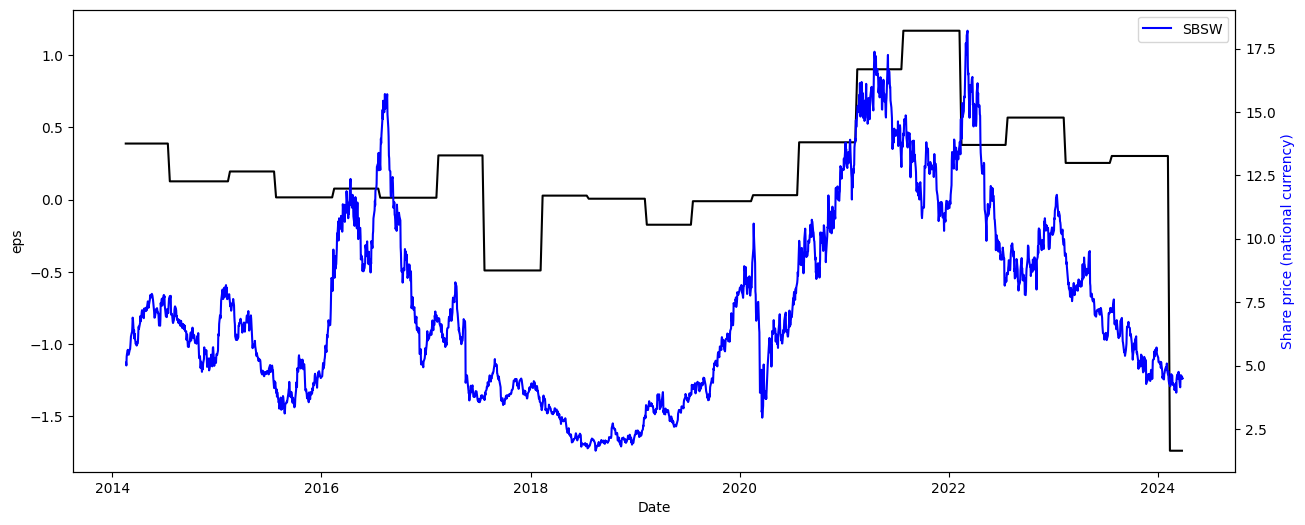

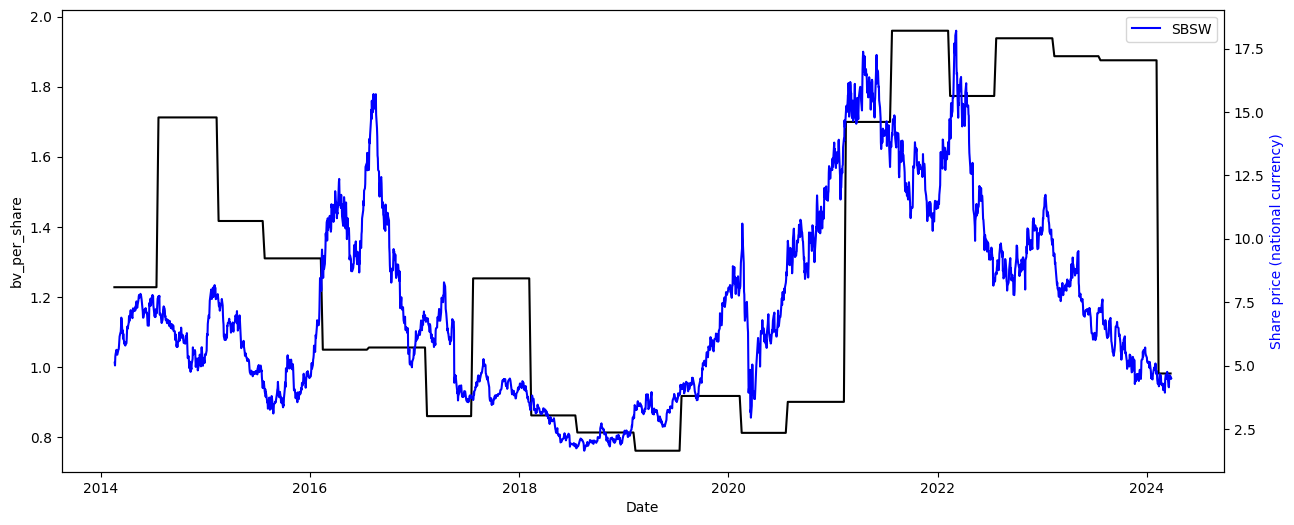

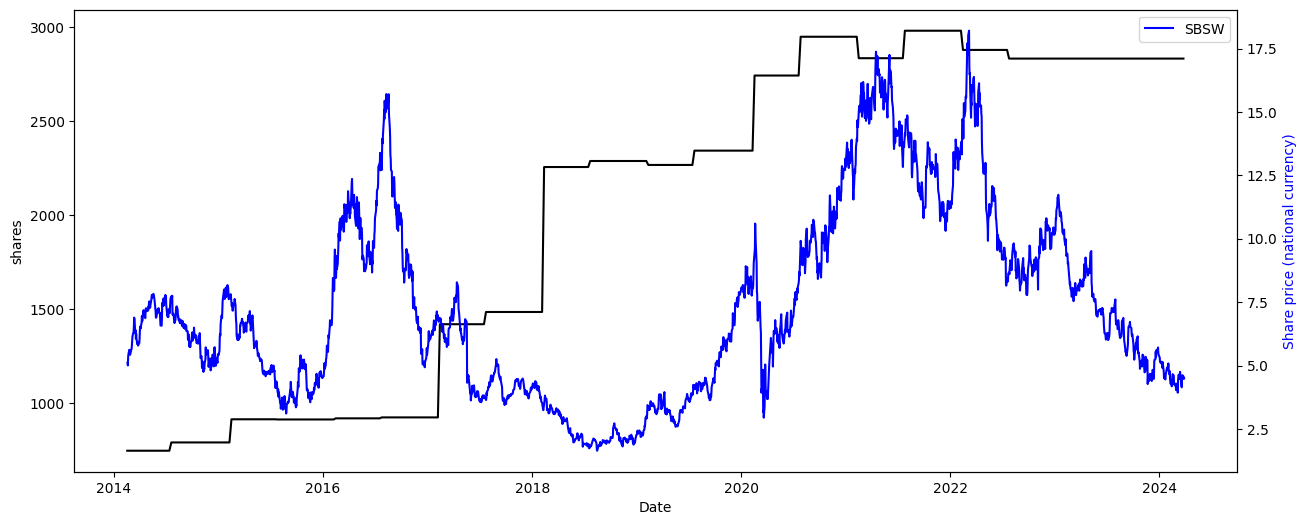

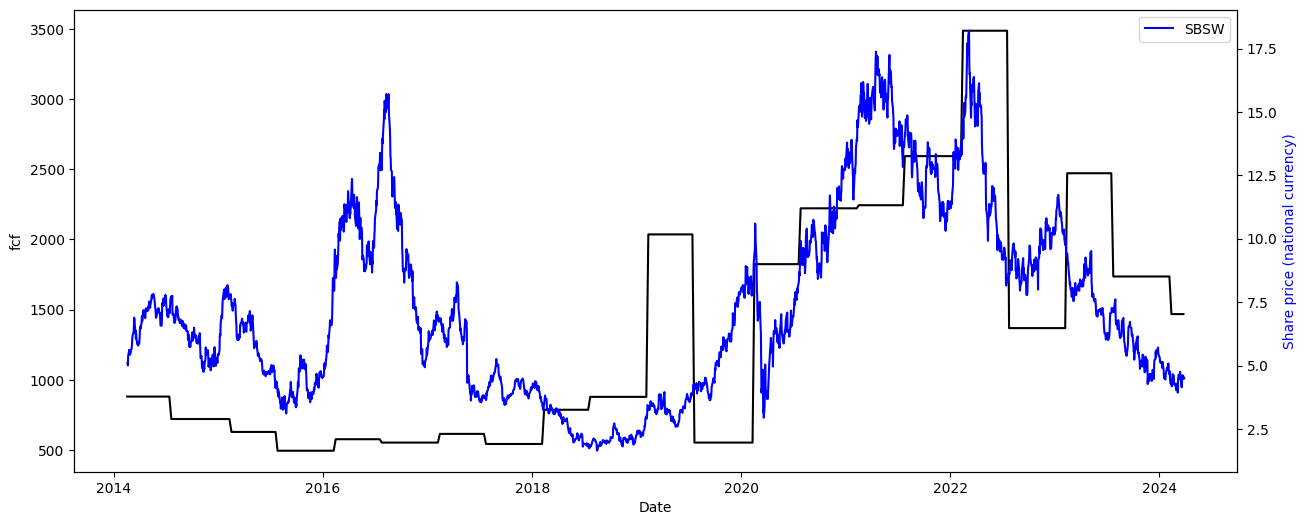

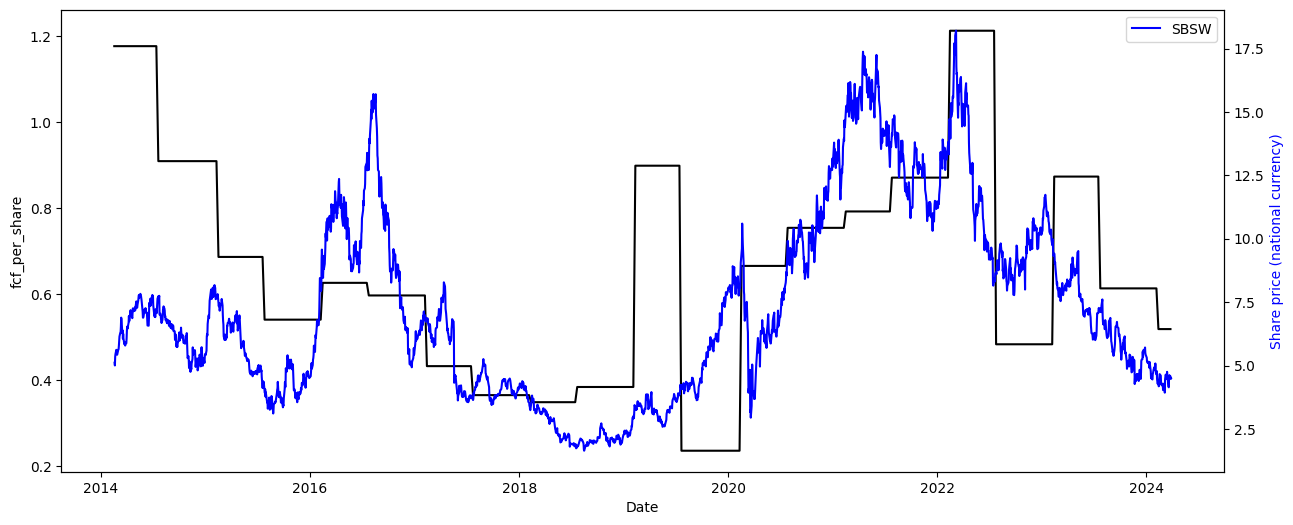

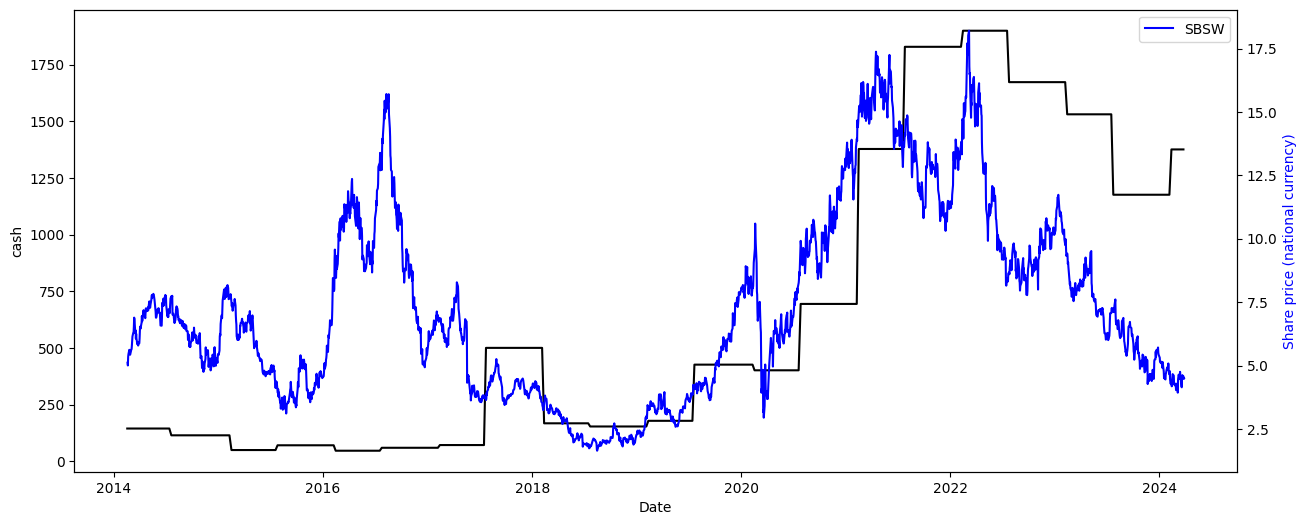

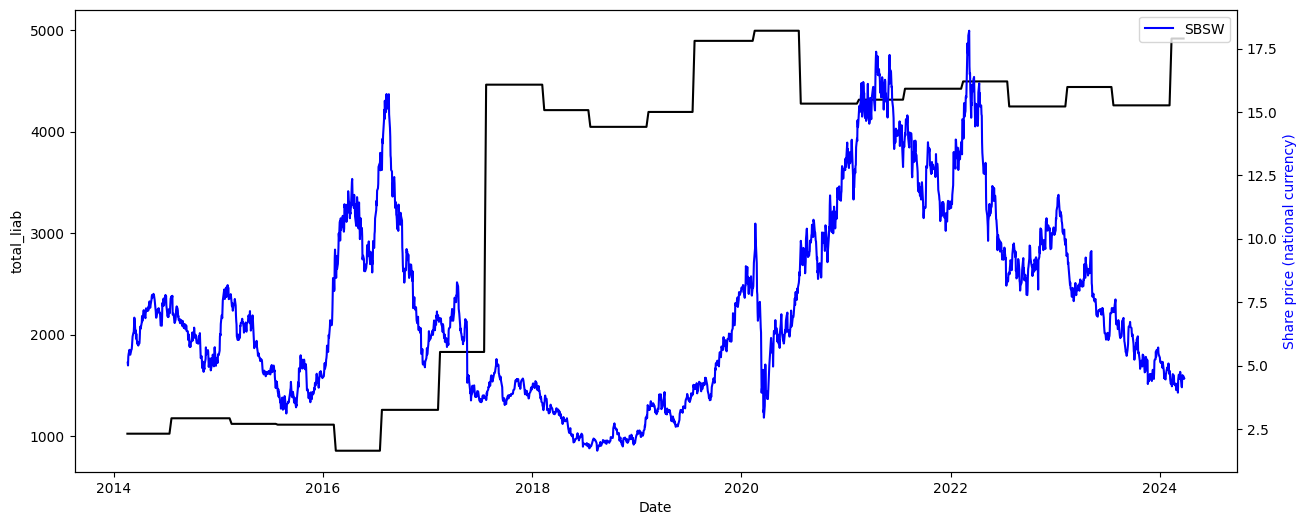

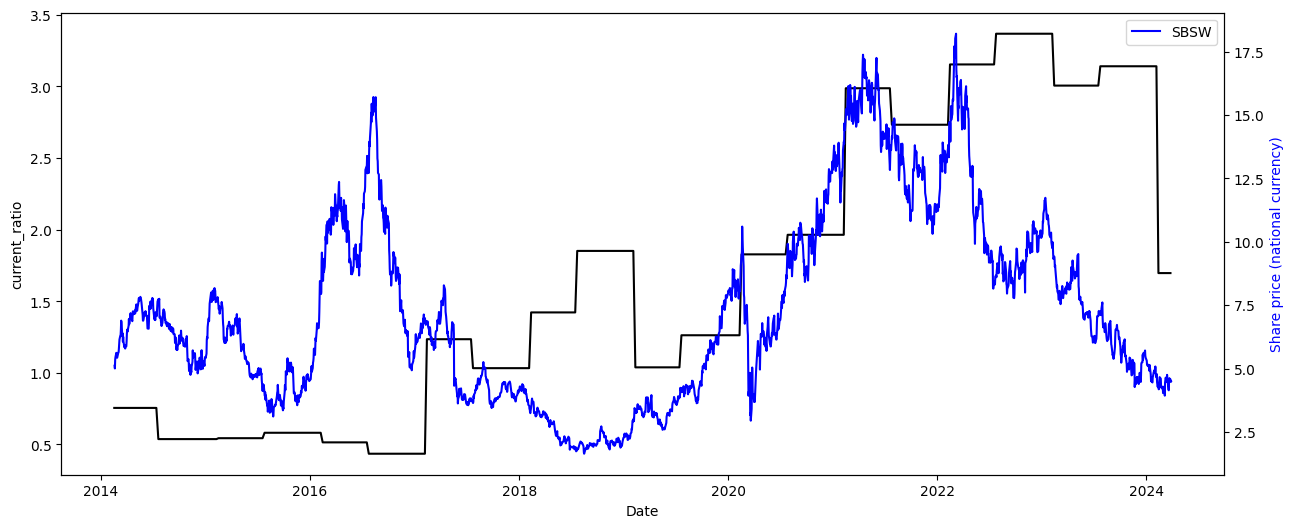

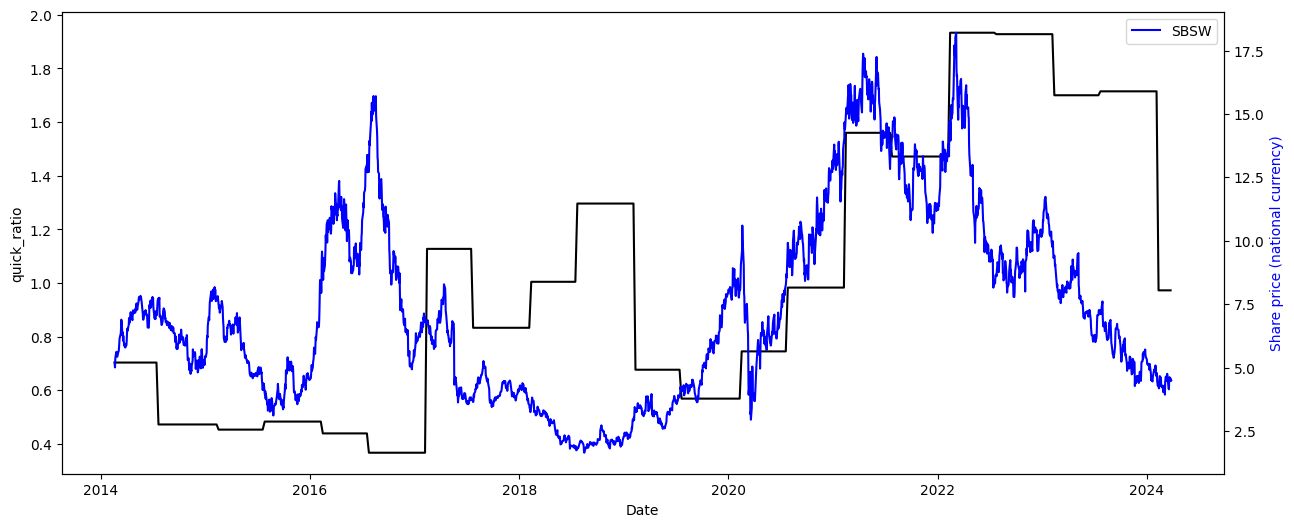

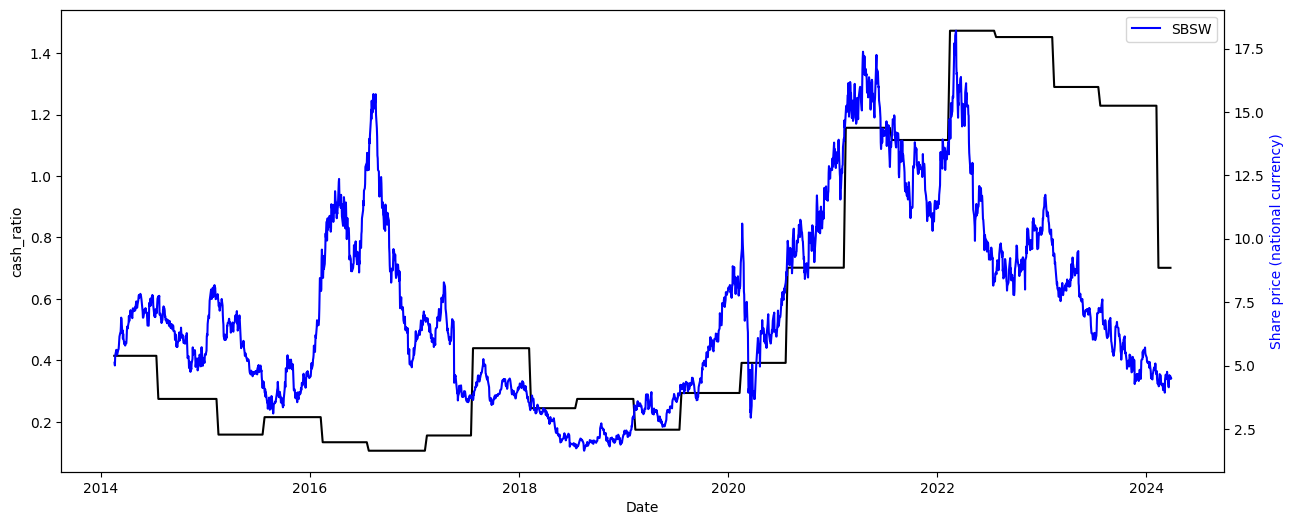

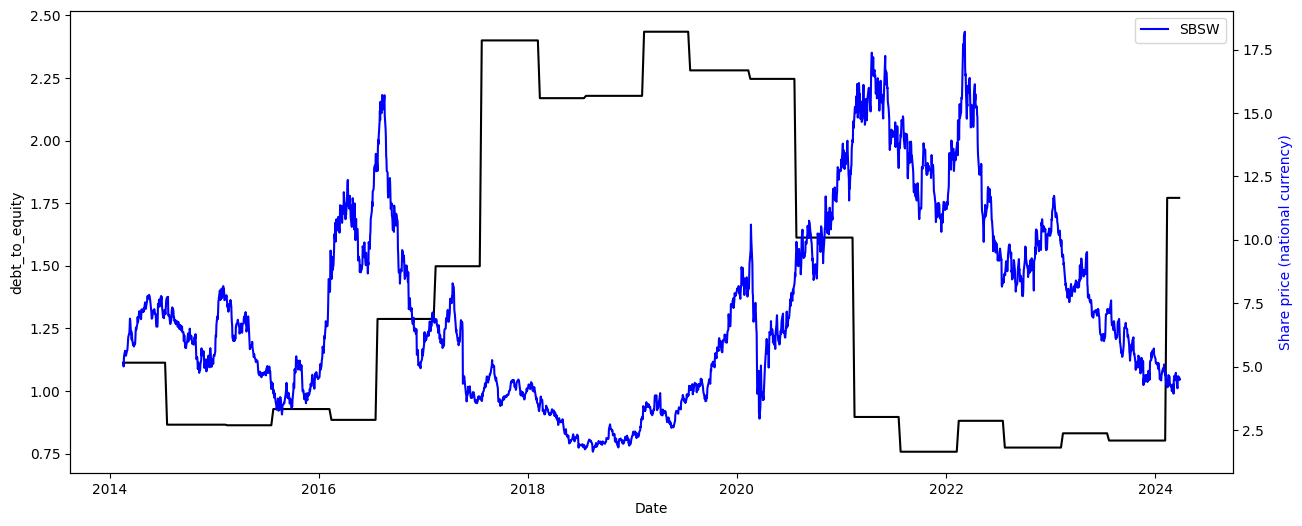

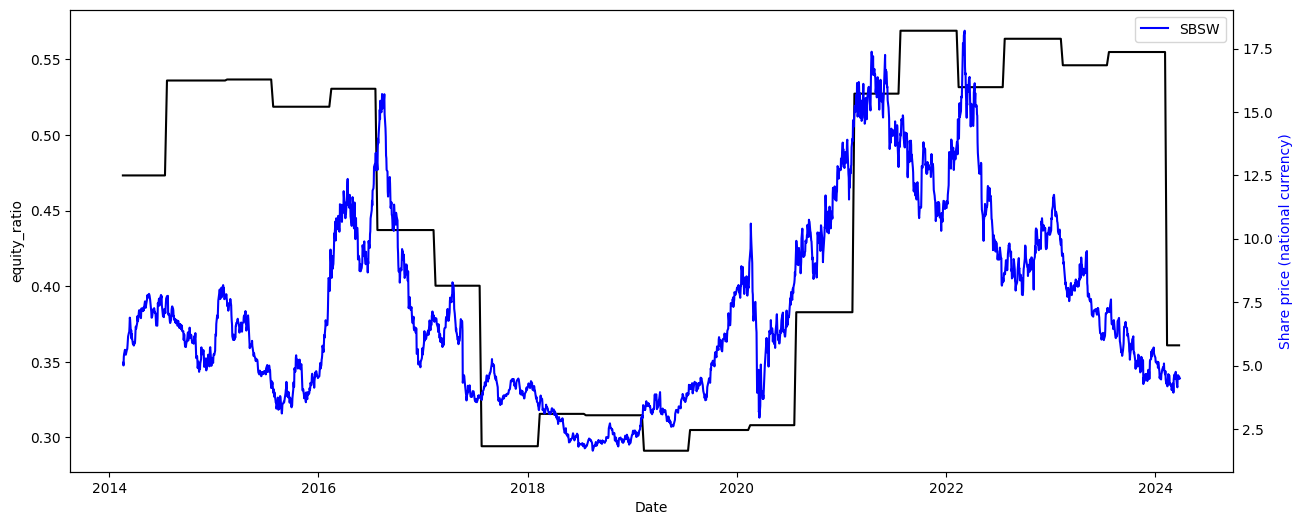

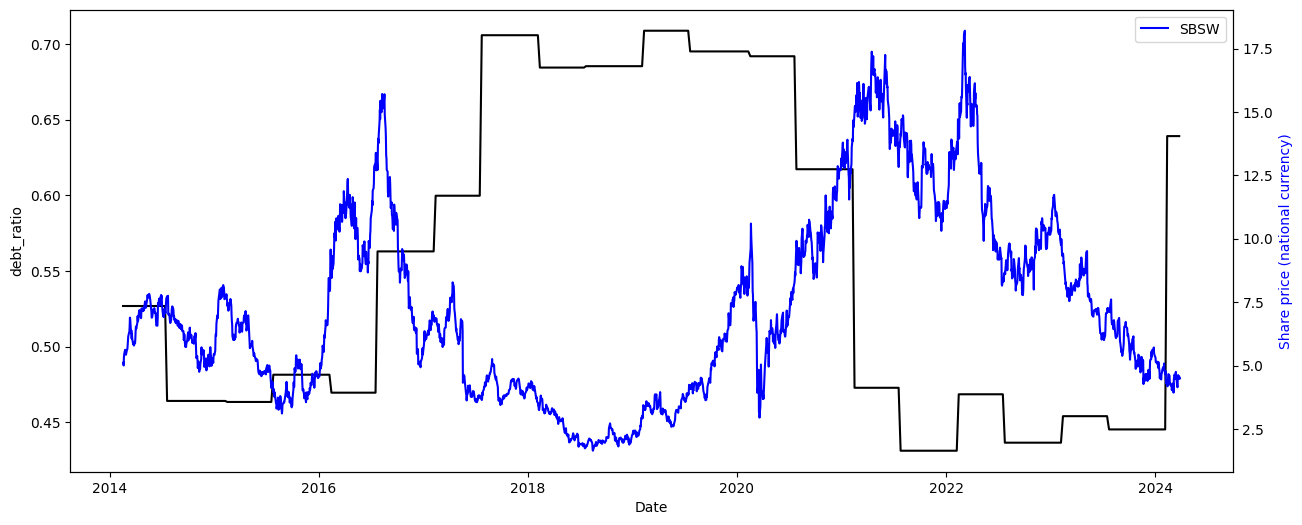

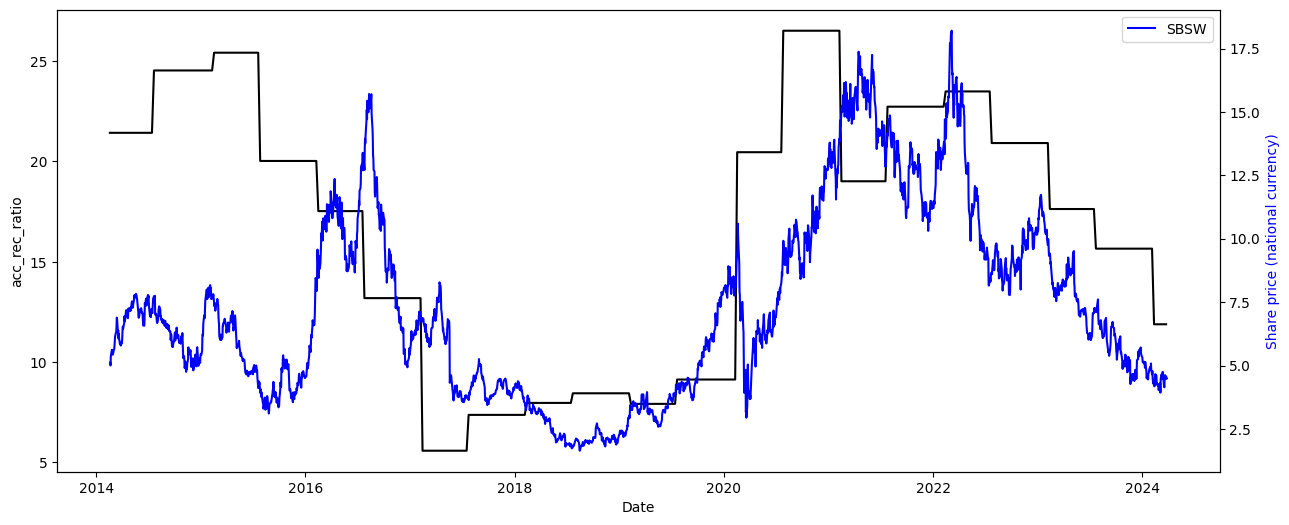

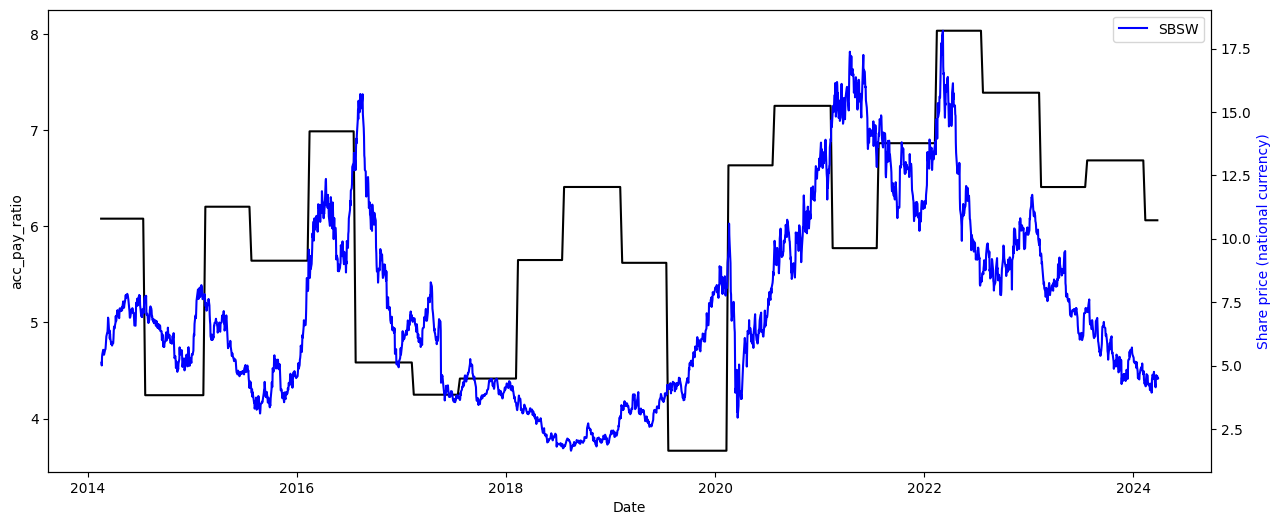

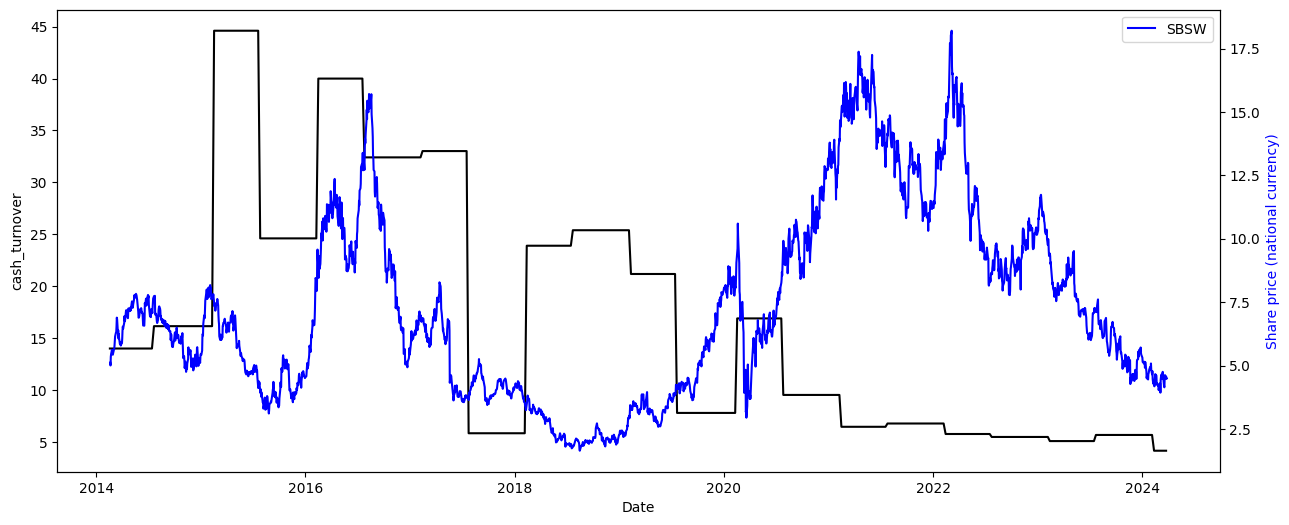

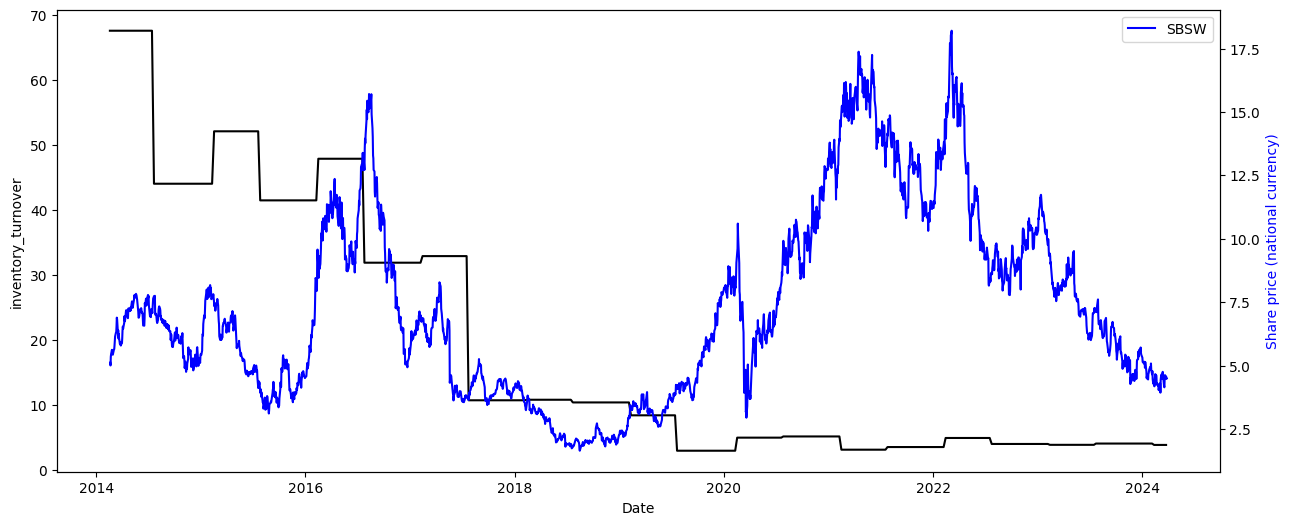

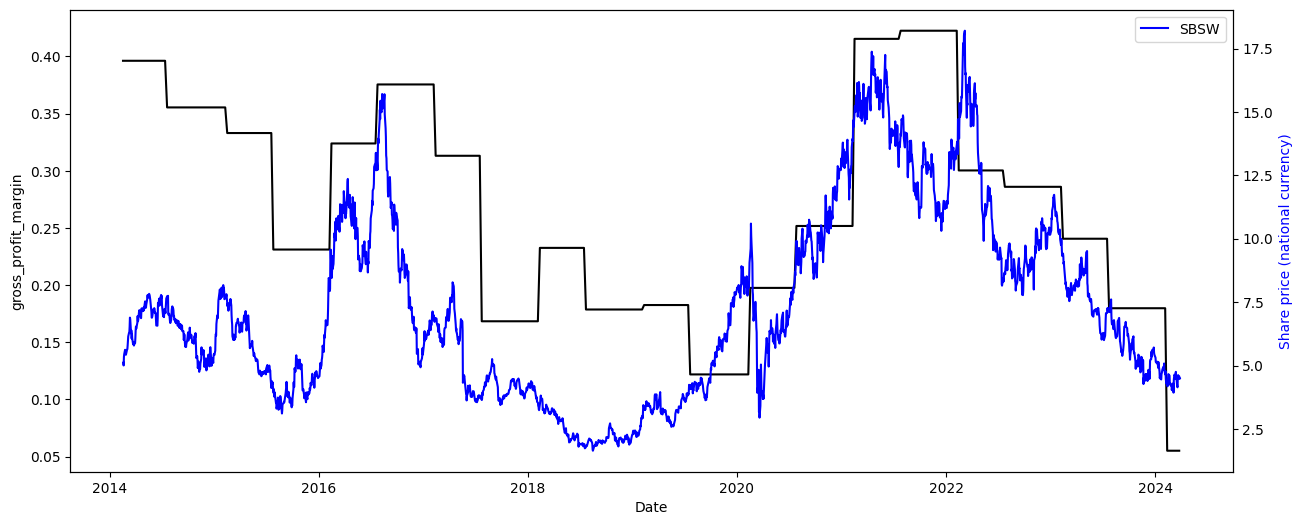

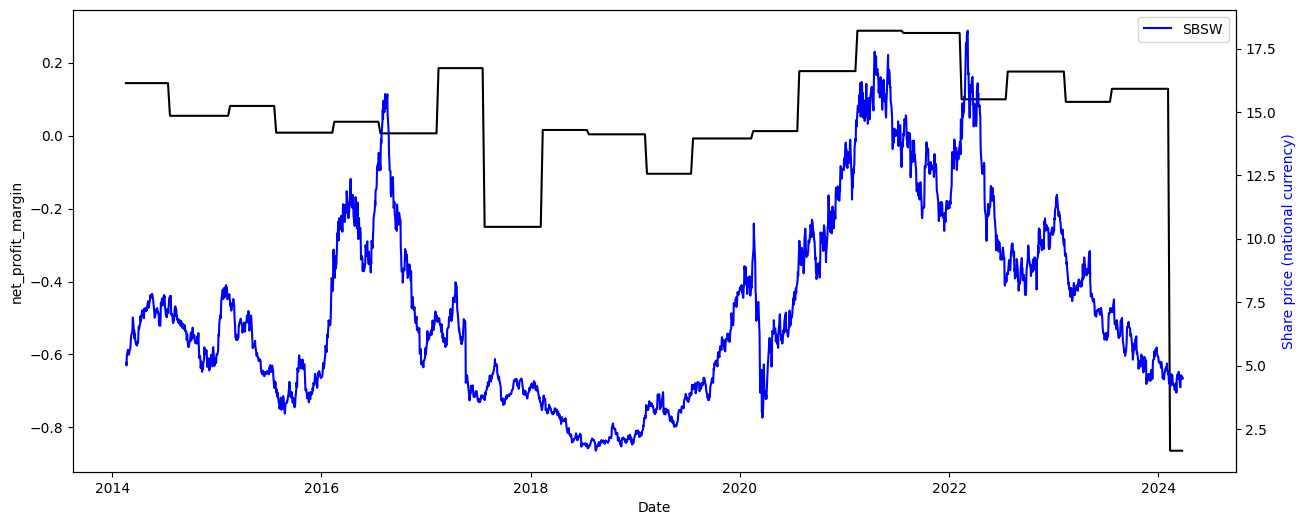

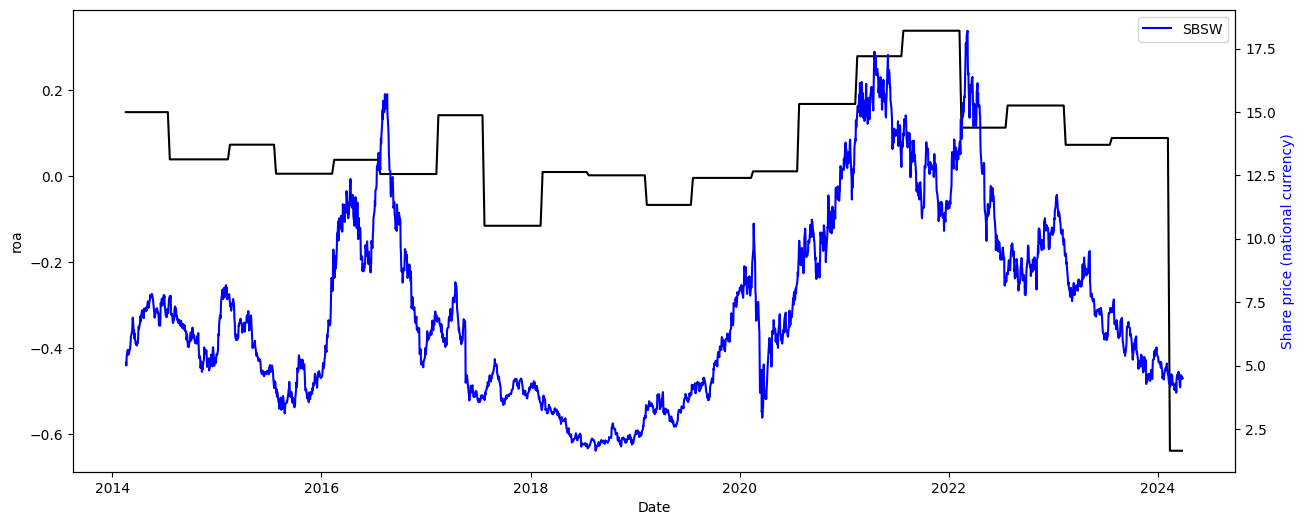

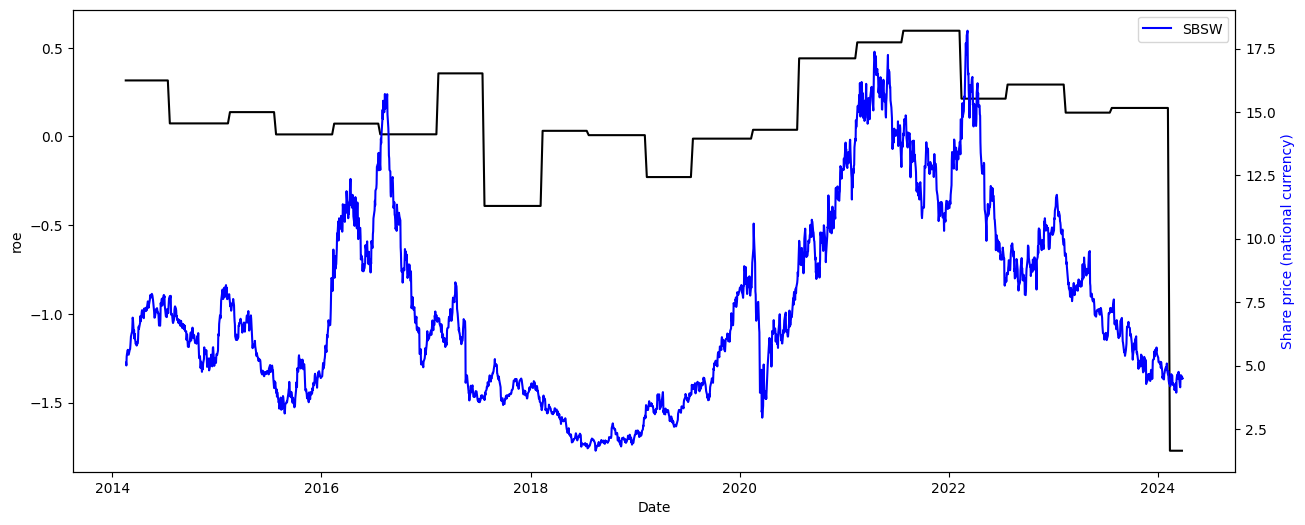

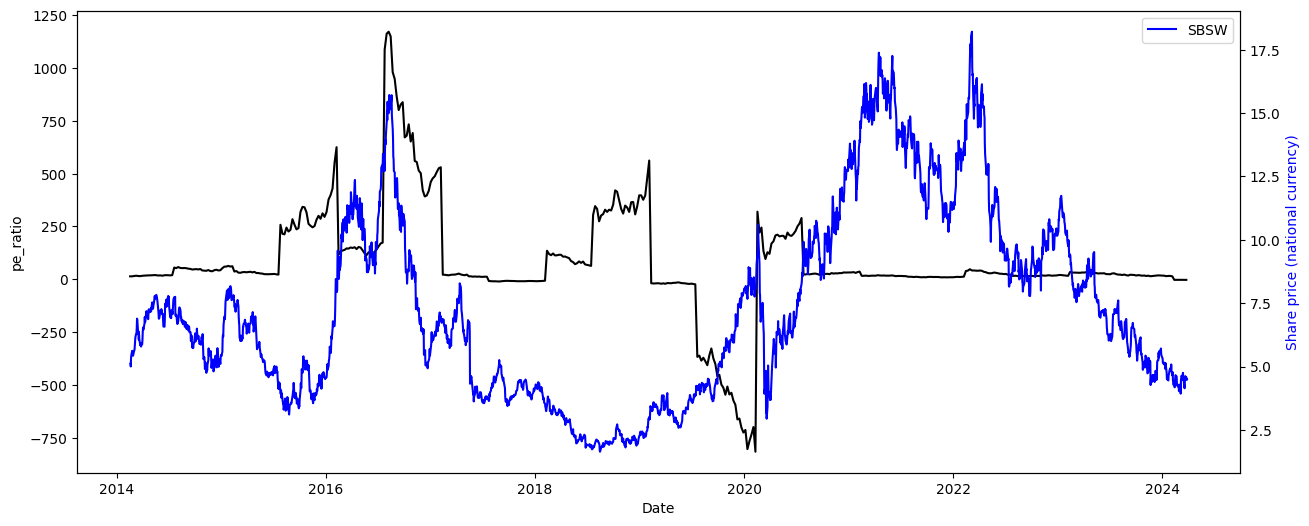

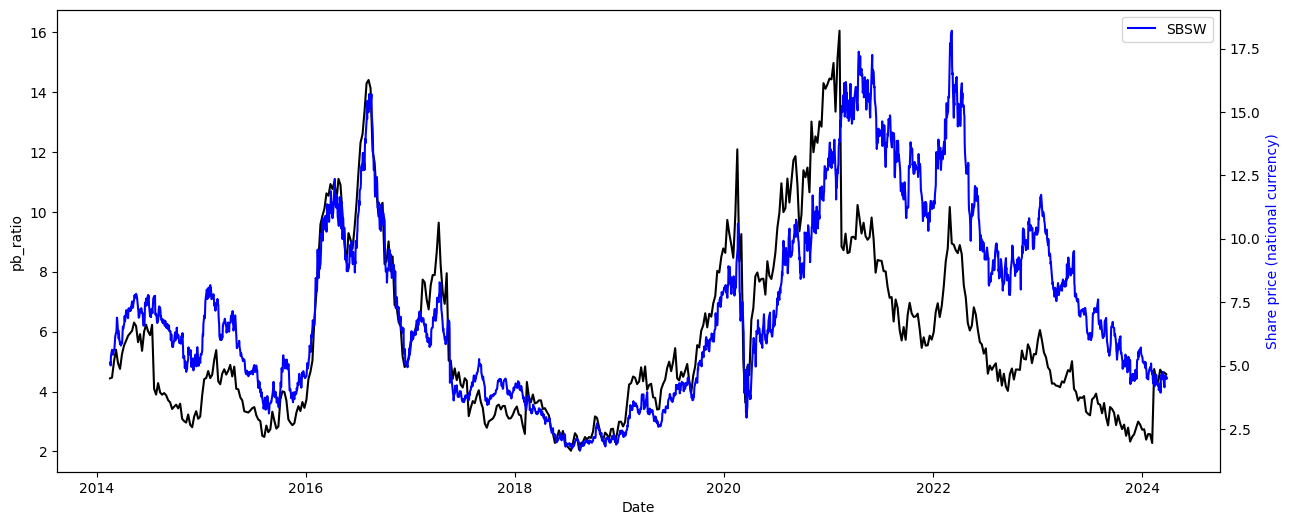

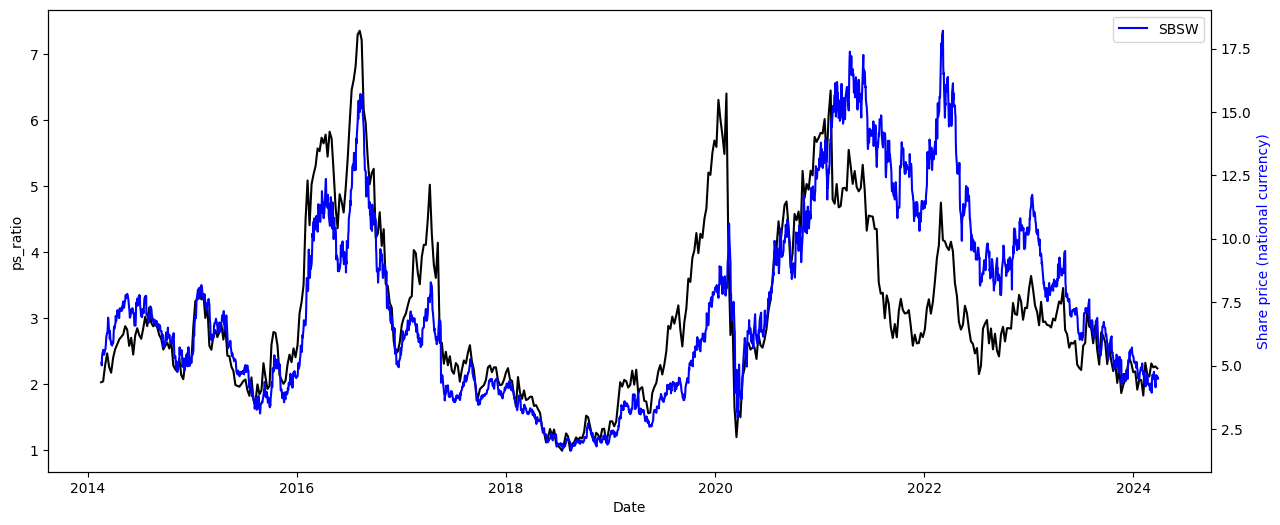

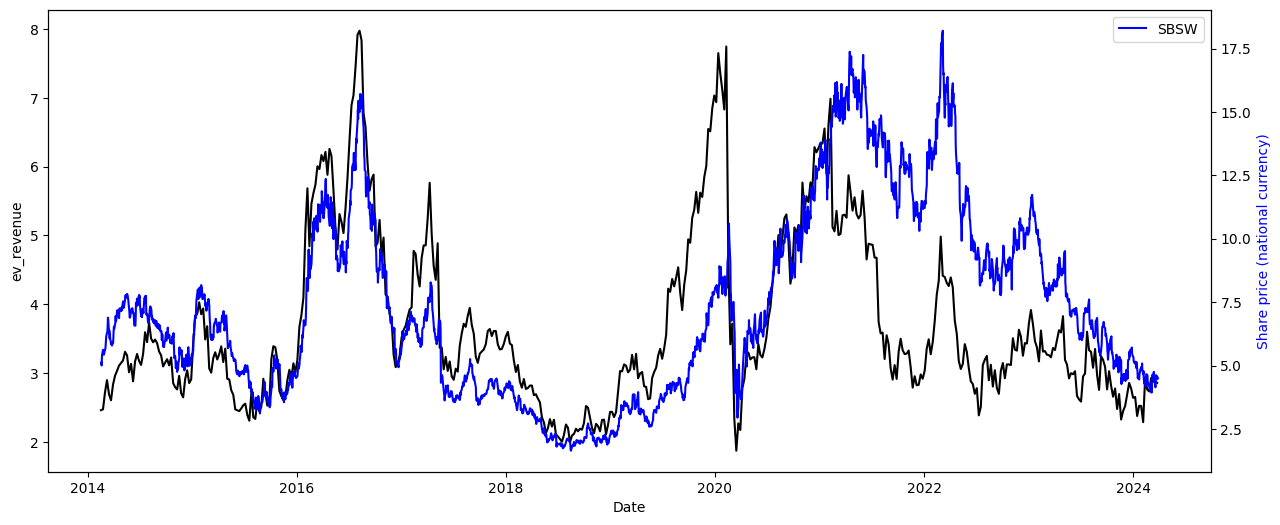

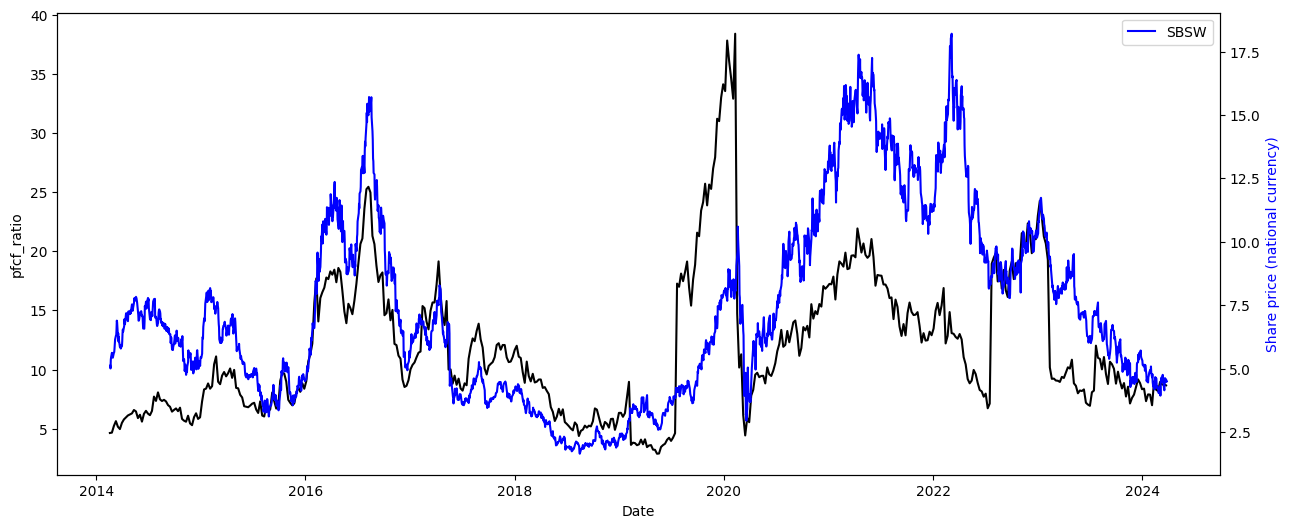

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

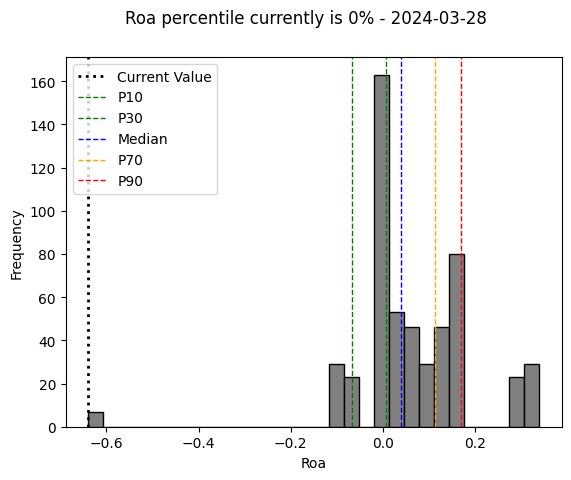

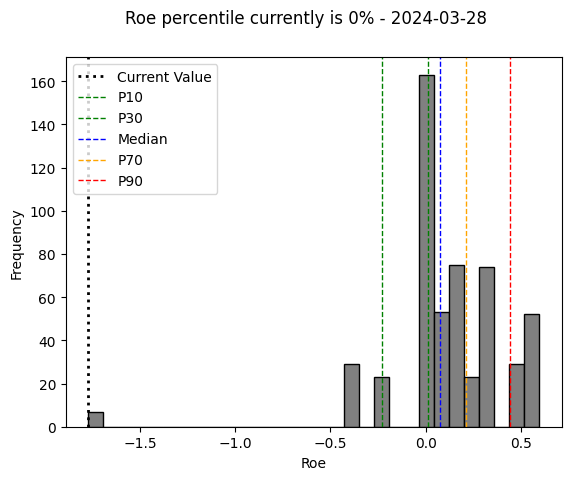

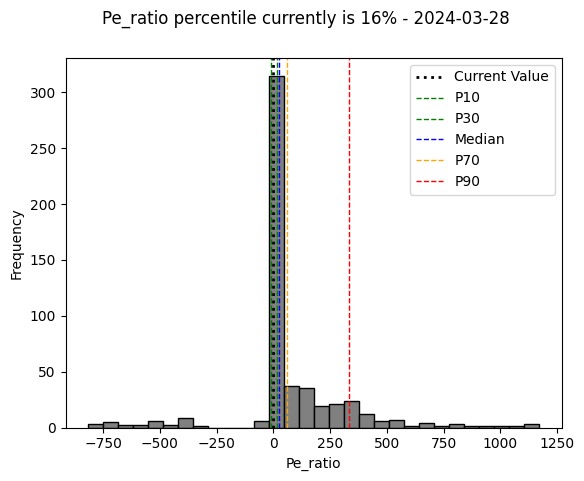

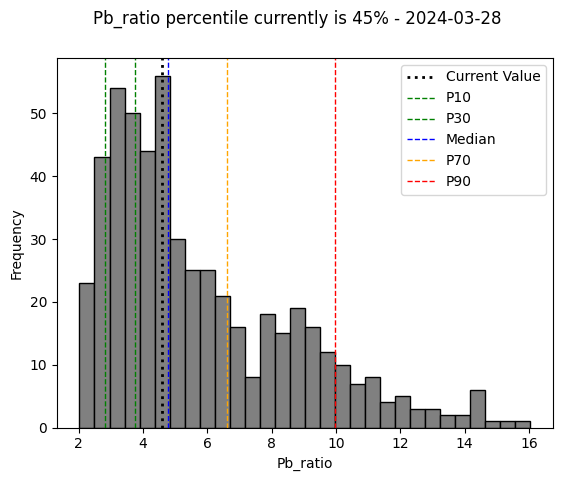

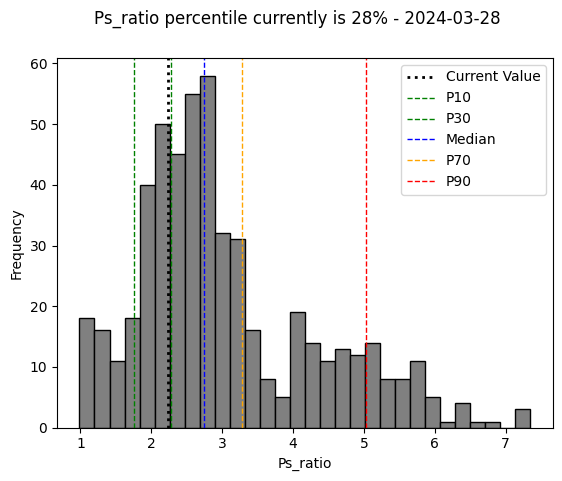

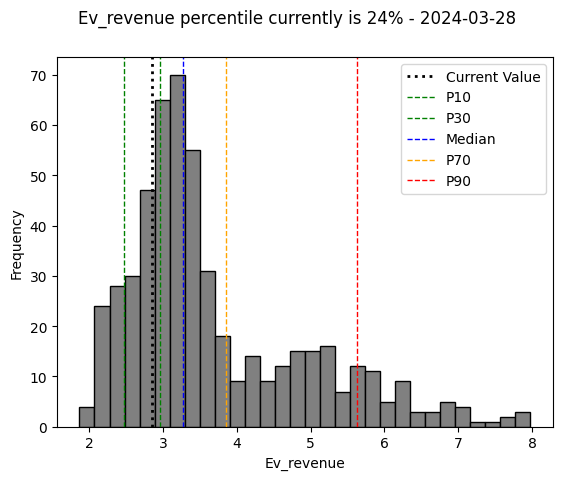

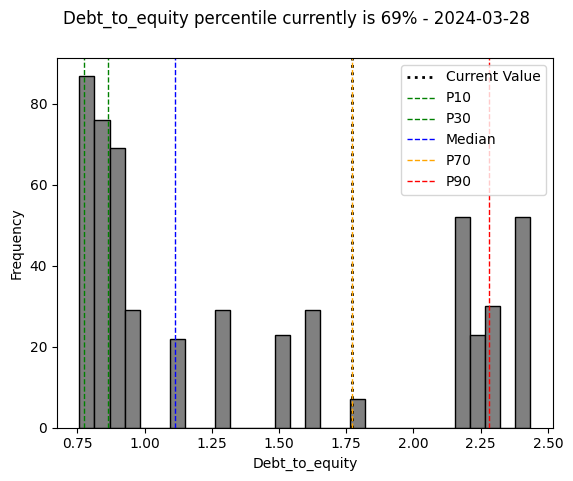

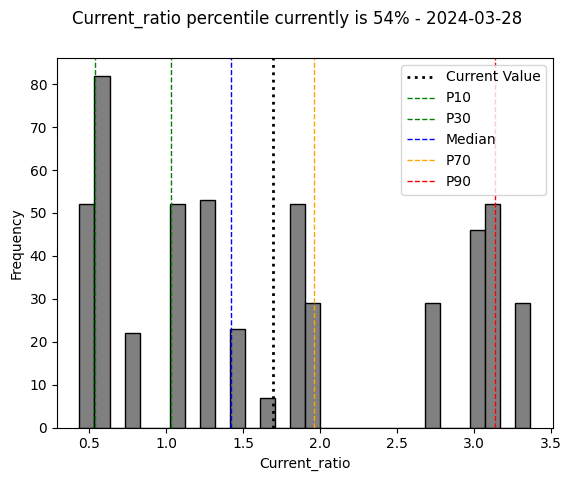

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.979517,-0.071225,0.306916,0.289613,0.134835,-0.533965,0.446836
roe,0.979517,1.000000,-0.033011,0.336852,0.308867,0.168980,-0.486415,0.365001
pe_ratio,-0.071225,-0.033011,1.000000,0.081511,-0.026882,-0.091396,-0.148287,-0.211347
pb_ratio,0.306916,0.336852,0.081511,1.000000,0.903315,0.858347,-0.081742,0.022007
ps_ratio,0.289613,0.308867,-0.026882,0.903315,1.000000,0.963378,-0.239846,-0.000020
ev_revenue,0.134835,0.168980,-0.091396,0.858347,0.963378,1.000000,-0.001310,-0.124830
debt_to_equity,-0.533965,-0.486415,-0.148287,-0.081742,-0.239846,-0.001310,1.000000,-0.286639
current_ratio,0.446836,0.365001,-0.211347,0.022007,-0.000020,-0.124830,-0.286639,1.000000


0 timestemos have been found!


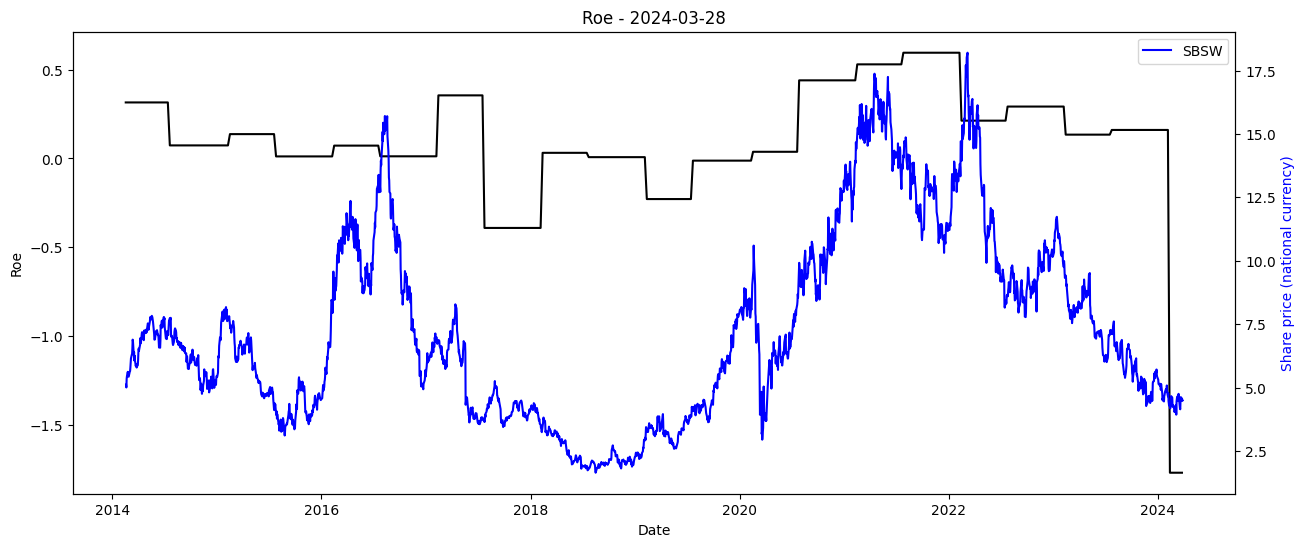

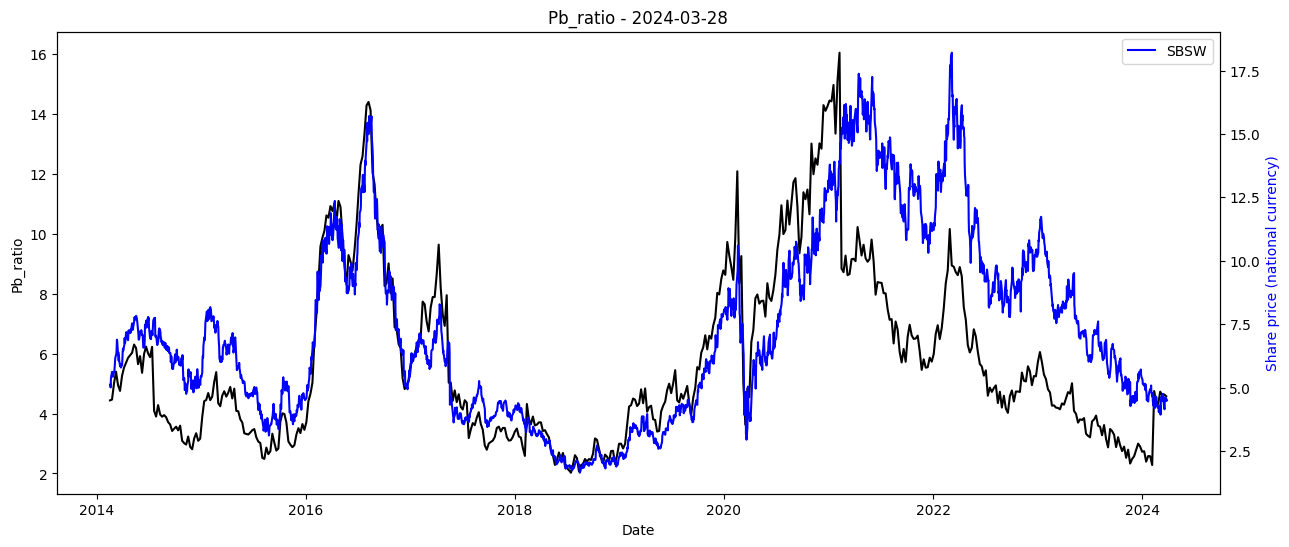

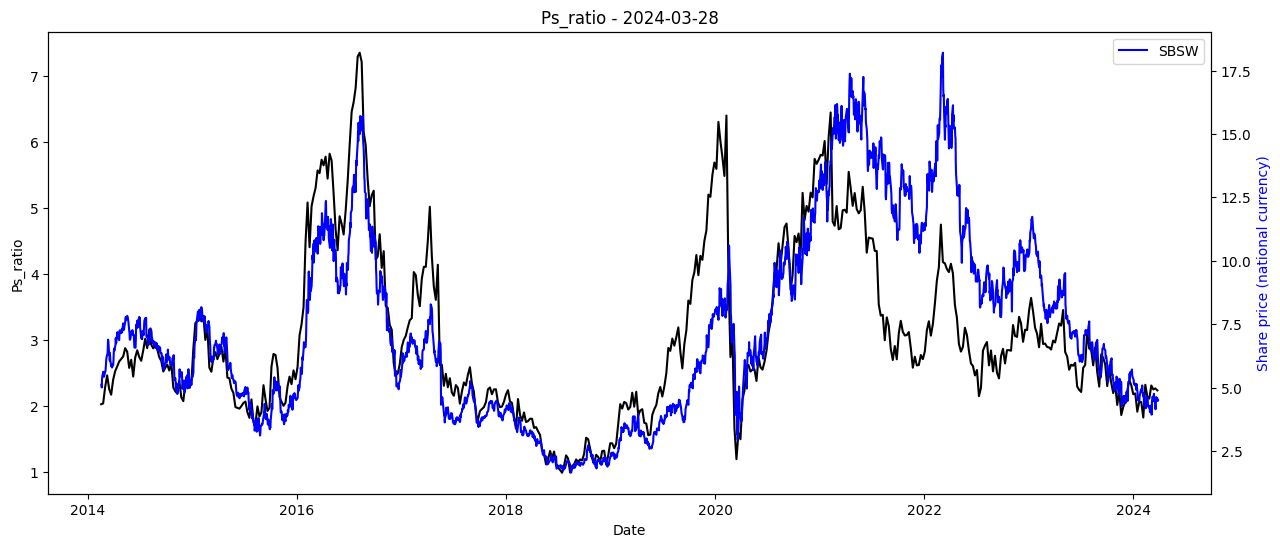

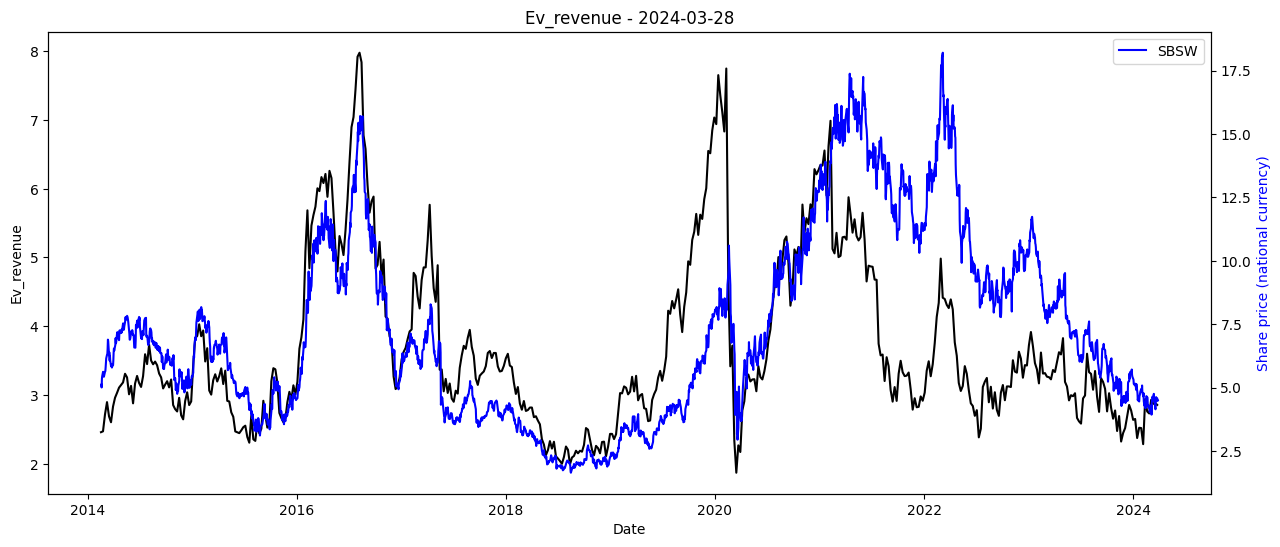

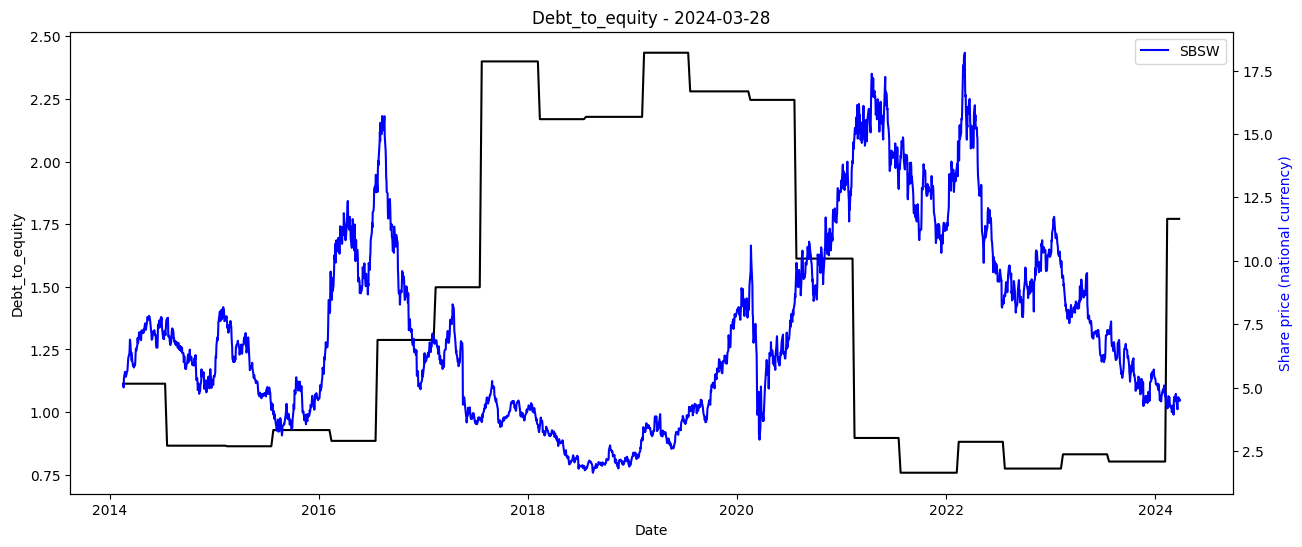

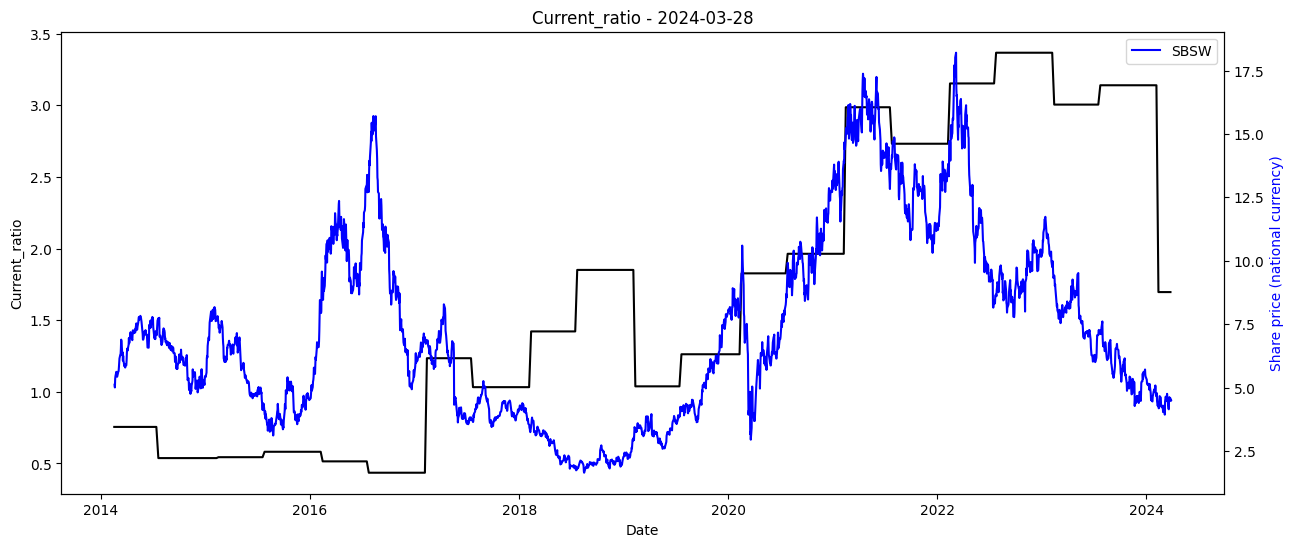

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )